Step 1: Generate underlying diffraction data 

In [43]:
from pymatgen.core.structure import Structure
from pymatgen.core.periodic_table import Element
from pymatgen.core.lattice import Lattice
from pymatgen.analysis.diffraction.xrd import XRDCalculator

import pandas as pd

import sys
import os
import numpy as np

#with a big dataset, it can be helpful to parallelize over chunks of the data
#read in the worker number 
try:
    worker_num = int(sys.argv[1])
    num_splits = int(sys.argv[2])
except:
    worker_num = 0
    num_splits = 1 #increase this if you are doing distributed preprocessing

print("worker_num", worker_num)
print("num_splits", num_splits)

try: 
    print('using data_dir', str(sys.argv[3]))
    data_dir = str(sys.argv[3])
except:
    ### NOTE: CHANGE THIS FOR YOUR LOCAL SYSTEM 
    data_dir = '/home/gridsan/tmackey/cdvae/data/mp_20_final_reproduction'
    print('using the default data_dir', data_dir)

#load in the data 
train_path = os.path.join(data_dir, 'train.csv')
val_path = os.path.join(data_dir, 'val.csv')
test_path = os.path.join(data_dir, 'test.csv')

train_df = pd.read_csv(train_path)
val_df = pd.read_csv(val_path)
test_df = pd.read_csv(test_path)

dataframes = {'train': train_df, 'val': val_df, 'test': test_df}

# Initialize the XRDCalculator with a wavelength of CuKa (1.54060 Å)
xrd_calculator = XRDCalculator(wavelength='CuKa')
from tqdm.auto import tqdm
tqdm.pandas()

def get_xrd_information(crystal_str):
    try: 
        crystal = Structure.from_str(crystal_str, fmt='cif')
    except:
        crystal = None

    try:  
        xrd = xrd_calculator.get_pattern(crystal)
    except: 
        xrd = None

    try: 
        x = xrd.x.tolist()
        y = xrd.y.tolist()
    except:
        x = None
        y = None

    try: 
        atomic_species = [Element(specie).Z for specie in crystal.species]
    except: 
        atomic_species = None

    return [xrd, x, y, atomic_species]

data_frames = {"train": train_df, "test": test_df, "val": val_df}

worker_dir = os.path.join(data_dir, "worker_data")
os.makedirs(worker_dir, exist_ok=True)

for name, df in data_frames.items():
    
    chunk_size = np.ceil(len(df)/num_splits)
    
    start_index = int(worker_num*chunk_size)
    end_index = int(min(start_index + chunk_size, len(df))) #prevents end index > len(df)
    
    print("start_index", start_index)
    print("end_index", end_index)

    sub_df = df.iloc[start_index:end_index].copy()
    sub_crystals = sub_df['cif'].progress_apply(get_xrd_information)
    sub_df['xrd'] = sub_crystals.progress_apply(lambda x: x[0])
    sub_df['xrd_peak_locations'] = sub_crystals.progress_apply(lambda x: x[1])
    sub_df['xrd_peak_intensities'] = sub_crystals.progress_apply(lambda x: x[2])
    sub_df['atomic_numbers'] = sub_crystals.progress_apply(lambda x: x[3])

    #save the csv
    sub_df.to_csv(os.path.join(worker_dir,f'{name}_xrd_{worker_num}.csv'), index=False)

worker_num 0
num_splits 100
using the default data_dir /home/gridsan/tmackey/cdvae/data/mp_20_final_reproduction
start_index 0
end_index 4


  0%|          | 0/4 [00:00<?, ?it/s]

/home/gridsan/tmackey/.conda/envs/cdvae/lib/python3.8/site-packages/pymatgen/io/cif.py:1168: UserWarning: Issues encountered while parsing CIF: Some fractional coordinates rounded to ideal values to avoid issues with finite precision.
  warnings.warn("Issues encountered while parsing CIF: " + "\n".join(self.warnings))


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

start_index 0
end_index 1


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

start_index 0
end_index 1


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

next step is merging 

In [44]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import os 

#assuming all of the data was stored as .pt dictionaries of string keys and graph values
num_workers = 1
dataset_names =  ['train', 'test', 'val']
data_dir = "/home/gridsan/tmackey/cdvae/data/mp_20_final_reproduction"
worker_dir = "/home/gridsan/tmackey/cdvae/data/mp_20_final_reproduction/worker_data/"

for name in dataset_names:
    total_df = pd.DataFrame()
    for worker_num in tqdm(range(num_workers)):
        df = pd.read_csv(os.path.join(worker_dir + f'{name}_xrd_{worker_num}.csv'))
        #add df without using append
        total_df = pd.concat([total_df, df])

    output_filepath = os.path.join(data_dir, f'{name}_xrd.csv')
    total_df.to_csv(output_filepath, index=False)
    print(f"Saved {name} dataset")

100%|██████████| 1/1 [00:00<00:00, 24.66it/s]


Saved train dataset


100%|██████████| 1/1 [00:00<00:00, 71.71it/s]


Saved test dataset


100%|██████████| 1/1 [00:00<00:00, 126.81it/s]


Saved val dataset


Step 2: Create the disc sim xrd information. This is no longer used in the model, but is still required as an input. Will likely be removed from the model dataloader soon. Upon which this section can be disregarded.

In [45]:
import pandas as pd

import sys
import os
import numpy as np
import ast
from tqdm.auto import tqdm
tqdm.pandas()

#read in the worker number 
try: 
    worker_num = int(sys.argv[1])
except: 
    worker_num = 0

num_splits = 1
data_dir = '/home/gridsan/tmackey/cdvae/data/mp_20_final_reproduction'

#load in the data 
train_df = pd.read_csv(os.path.join(data_dir,'train_xrd.csv'))
test_df = pd.read_csv(os.path.join(data_dir, 'test_xrd.csv'))
#train and test commented out for testing purposes
val_df = pd.read_csv(os.path.join(data_dir, 'val_xrd.csv'))

#let's pull out the diffraction patterns ahead of time 
def simulate_xrd(peak_locations, peak_intensities, lower_bound = 5, upper_bound = 75, dimensions = 200):
    interval =  (upper_bound - lower_bound)/dimensions
    sim_positions = np.arange(lower_bound, upper_bound, interval)
    # Create an empty intensity array for the simulation
    sim_intensities = np.zeros_like(sim_positions)
    
    # Loop over all simulated positions
    for i, pos in enumerate(sim_positions):
        # Find peak locations within 0.25° of the current simulated position
        close_peaks = [(loc, intensity) for loc, intensity in zip(peak_locations, peak_intensities) if abs(loc - pos) <= interval/2]
        
        # If there are close peaks, sum the intensities among those peaks
        if close_peaks:
            intensities = np.array([intensity for loc, intensity in close_peaks])
            sim_intensities[i] = np.sum(intensities)
    
    sim_intensities = 100*sim_intensities / max(sim_intensities)
    
    return sim_intensities

data_frames = {"train": train_df, "test": test_df, "val": val_df}

worker_dir = os.path.join(data_dir, "worker_data")
os.makedirs(worker_dir, exist_ok=True)

for name, df in data_frames.items():
    
    chunk_size = np.ceil(len(df)/num_splits)
    
    start_index = int(worker_num*chunk_size)
    end_index = int(min(start_index + chunk_size, len(df))) #prevents end index > len(df)
    sub_df = df.iloc[start_index:end_index].copy()

    sub_df['xrd_peak_locations'] = sub_df['xrd_peak_locations'].progress_apply(ast.literal_eval)
    sub_df['xrd_peak_intensities'] = sub_df['xrd_peak_intensities'].progress_apply(ast.literal_eval)
    sub_df['disc_sim_xrd'] = sub_df.progress_apply(lambda row: simulate_xrd(row['xrd_peak_locations'], row['xrd_peak_intensities']), axis=1)    

    #save
    sub_df.to_csv(os.path.join(worker_dir, f'{name}_xrd_disc_sim_{worker_num}.csv'), index=False)

  0%|          | 0/361 [00:00<?, ?it/s]

  0%|          | 0/361 [00:00<?, ?it/s]

  0%|          | 0/361 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

merge

In [46]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import os 
#assuming all of the data was stored as .pt dictionaries of string keys and graph values
num_workers = 1
dataset_names =  ['train', 'test', 'val']
data_dir = "/home/gridsan/tmackey/cdvae/data/mp_20_final_reproduction"
worker_dir = "/home/gridsan/tmackey/cdvae/data/mp_20_final_reproduction/worker_data"

for name in dataset_names:
    total_df = pd.DataFrame()
    for worker_num in tqdm(range(num_workers)):
        df = pd.read_csv(os.path.join(worker_dir, f'{name}_xrd_disc_sim_{worker_num}.csv'))
        # print(len(df))
        #add df without using append
        total_df = pd.concat([total_df, df])
    output_filepath = os.path.join(data_dir, f'{name}_xrd_disc_sim.csv')
    total_df.to_csv(output_filepath, index=False)
    print(f"Saved {name} dataset")

100%|██████████| 1/1 [00:00<00:00, 24.50it/s]


Saved train dataset


100%|██████████| 1/1 [00:00<00:00, 101.32it/s]


Saved test dataset


100%|██████████| 1/1 [00:00<00:00, 129.68it/s]

Saved val dataset


Step 3: graph data 

In [47]:
import numpy as np
import pandas as pd
import networkx as nx
import torch
import copy
import itertools

from pymatgen.core.structure import Structure
from pymatgen.core.lattice import Lattice
from pymatgen.analysis.graphs import StructureGraph
from pymatgen.analysis import local_env

from networkx.algorithms.components import is_connected

from sklearn.metrics import accuracy_score, recall_score, precision_score

from torch_scatter import scatter

from p_tqdm import p_umap

import ast
#import the random function library
import random

import os 

from tqdm.auto import tqdm
tqdm.pandas()

CrystalNN = local_env.CrystalNN(
    distance_cutoffs=None, x_diff_weight=-1, porous_adjustment=False)

from cdvae.common.data_utils import * 

import sys

#read in the worker number 
try: 
    worker_num = int(sys.argv[1])
except: 
    worker_num = 0

#read in the number of splits
try:
    num_splits = int(sys.argv[2])
except:
    num_splits = 1

data_dir = '/home/gridsan/tmackey/cdvae/data/mp_20_final_reproduction'

#load in the data 
train_df = pd.read_csv(os.path.join(data_dir, 'train_xrd.csv'))
test_df = pd.read_csv(os.path.join(data_dir, 'test_xrd.csv'))
val_df = pd.read_csv(os.path.join(data_dir, 'val_xrd.csv'))

def build_crystal(crystal_str, niggli=True, primitive=False):
    try: 
        """Build crystal from cif string."""
        crystal = Structure.from_str(crystal_str, fmt='cif')

        if primitive:
            crystal = crystal.get_primitive_structure()

        if niggli:
            crystal = crystal.get_reduced_structure()

        canonical_crystal = Structure(
            lattice=Lattice.from_parameters(*crystal.lattice.parameters),
            species=crystal.species,
            coords=crystal.frac_coords,
            coords_are_cartesian=False,
        )
        # match is gaurantteed because cif only uses lattice params & frac_coords
        # assert canonical_crystal.matches(crystal)
        return canonical_crystal
    except: 
        return None 

def build_crystal_graph(crystal, graph_method='crystalnn'):
    try: 
        """
        """

        if graph_method == 'crystalnn':
            crystal_graph = StructureGraph.with_local_env_strategy(
                crystal, CrystalNN)
        elif graph_method == 'none':
            pass
        else:
            raise NotImplementedError

        frac_coords = crystal.frac_coords
        atom_types = crystal.atomic_numbers
        lattice_parameters = crystal.lattice.parameters
        lengths = lattice_parameters[:3]
        angles = lattice_parameters[3:]

        assert np.allclose(crystal.lattice.matrix,
                        lattice_params_to_matrix(*lengths, *angles))

        edge_indices, to_jimages = [], []
        if graph_method != 'none':
            for i, j, to_jimage in crystal_graph.graph.edges(data='to_jimage'):
                edge_indices.append([j, i])
                to_jimages.append(to_jimage)
                edge_indices.append([i, j])
                to_jimages.append(tuple(-tj for tj in to_jimage))

        atom_types = np.array(atom_types)
        lengths, angles = np.array(lengths), np.array(angles)
        edge_indices = np.array(edge_indices)
        to_jimages = np.array(to_jimages)
        num_atoms = atom_types.shape[0]

        return frac_coords, atom_types, lengths, angles, edge_indices, to_jimages, num_atoms
    except: 
        return None
    
data_frames = {"train": train_df, "test": test_df, "val": val_df}
worker_dir = os.path.join(data_dir, "worker_dir")
os.makedirs(worker_dir, exist_ok=True)

for name, df in data_frames.items():
    
    chunk_size = np.ceil(len(df)/num_splits)
    
    start_index = int(worker_num*chunk_size)
    end_index = int(min(start_index + chunk_size, len(df))) #prevents end index > len(df)
    sub_df = df.iloc[start_index:end_index].copy()
    sub_crystals = sub_df['cif'].progress_apply(build_crystal)
    sub_graphs = sub_crystals.progress_apply(build_crystal_graph)

    materials_ids = sub_df['material_id'].values

    #make a dictionary using the materials_ids as keys and the graphs as values
    graph_dict = dict(zip(materials_ids, sub_graphs))

    #save the dictionary to a file
    torch.save(graph_dict, os.path.join(worker_dir, '{}_{}.pt'.format(name, worker_num)))
    
    print('Saved {}_{}.pt'.format(name, worker_num))

  0%|          | 0/361 [00:00<?, ?it/s]

/home/gridsan/tmackey/.conda/envs/cdvae/lib/python3.8/site-packages/pymatgen/io/cif.py:1168: UserWarning: Issues encountered while parsing CIF: Some fractional coordinates rounded to ideal values to avoid issues with finite precision.
  warnings.warn("Issues encountered while parsing CIF: " + "\n".join(self.warnings))


  0%|          | 0/361 [00:00<?, ?it/s]

Saved train_0.pt


  0%|          | 0/46 [00:00<?, ?it/s]

/home/gridsan/tmackey/.conda/envs/cdvae/lib/python3.8/site-packages/pymatgen/io/cif.py:1168: UserWarning: Issues encountered while parsing CIF: Some fractional coordinates rounded to ideal values to avoid issues with finite precision.
  warnings.warn("Issues encountered while parsing CIF: " + "\n".join(self.warnings))


  0%|          | 0/46 [00:00<?, ?it/s]

Saved test_0.pt


  0%|          | 0/46 [00:00<?, ?it/s]

/home/gridsan/tmackey/.conda/envs/cdvae/lib/python3.8/site-packages/pymatgen/io/cif.py:1168: UserWarning: Issues encountered while parsing CIF: Some fractional coordinates rounded to ideal values to avoid issues with finite precision.
  warnings.warn("Issues encountered while parsing CIF: " + "\n".join(self.warnings))


  0%|          | 0/46 [00:00<?, ?it/s]

Saved val_0.pt


Merging 

In [48]:
import numpy as np
import torch 
from tqdm import tqdm

#assuming all of the data was stored as .pt dictionaries of string keys and graph values
num_workers = 1 
dataset_names =  ['train', 'test', 'val']

data_dir = '/home/gridsan/tmackey/cdvae/data/mp_20_final_reproduction'
worker_dir = os.path.join(data_dir, "worker_dir")

for name in dataset_names:
    total_dict = {}
    for worker_num in tqdm(range(num_workers)):
        chunk = torch.load(os.path.join(worker_dir, '{}_{}.pt'.format(name, worker_num)))
        total_dict.update(chunk)
    torch.save(total_dict, os.path.join(data_dir, '{}.pt'.format(name)))
    print('Saved {}.pt'.format(name))

100%|██████████| 1/1 [00:00<00:00, 47.85it/s]


Saved train.pt


100%|██████████| 1/1 [00:00<00:00, 236.25it/s]


Saved test.pt


100%|██████████| 1/1 [00:00<00:00, 344.81it/s]

Saved val.pt


Step 4: Generate the pseudo-voights. This notebook will be for the non-augmented data, so we will leave out the other possible peak shapes

In [49]:
import pandas as pd
import numpy as np
import argparse
import os
import random
import torch

try:
    # Argument parsing
    parser = argparse.ArgumentParser(description='Parallel XRD Simulation')
    parser.add_argument('--n_workers', type=int, help='Total number of workers')
    parser.add_argument('--worker_num', type=int, help='Current worker number (0-indexed)')
    args = parser.parse_args()

    n_workers = args.n_workers
    worker_num = args.worker_num
except:
    n_workers = 1
    worker_num = 0
    
data_dir = '/home/gridsan/tmackey/cdvae/data/mp_20_final_reproduction'

train_path = os.path.join(data_dir, 'train_xrd.csv')
val_path = os.path.join(data_dir, 'val_xrd.csv')
test_path = os.path.join(data_dir, 'test_xrd.csv')

train_df = pd.read_csv(train_path)
val_df = pd.read_csv(val_path)
test_df = pd.read_csv(test_path)

dataframes = {'train': train_df, 'val': val_df, 'test': test_df}

for name, data in dataframes.items():
    data['xrd_peak_locations'] = data['xrd_peak_locations'].apply(
        lambda x: [float(i) for i in x.strip('[]').split(',')]
    )

    #make sure we can read in the diffraction patterns
    data['xrd_peak_intensities'] = data['xrd_peak_intensities'].apply(
        lambda x: [float(i) for i in x.strip('[]').split(',')]
    )

def caglioti_fwhm(theta, U, V, W):
    """
    Calculate the FWHM using the Caglioti formula.
    theta: float, the angle in degrees
    U, V, W: Caglioti parameters
    """
    rad_theta = np.radians(theta / 2)  # Convert theta to radians
    return (U * np.tan(rad_theta)**2 + V * np.tan(rad_theta) + W)**0.5

def pseudo_voigt(x, center, amplitude, U, V, W, eta, noise_sd=0.0):
    """
    Pseudo-Voigt function using Caglioti FWHM.
    x: array-like, the independent variable
    center: float, the center of the peak
    amplitude: float, the height of the peak
    U, V, W: Caglioti parameters
    eta: float, the fraction of the Lorentzian component (0 <= eta <= 1)
    """
    fwhm = caglioti_fwhm(center, U, V, W)
    sigma = fwhm / (2 * np.sqrt(2 * np.log(2)))  # Convert FWHM to sigma for Gaussian
    # Generate random noise from a normal distribution
    noise = np.random.normal(0, noise_sd)

    noisy_percentage = (100 + noise_sd) / 100 
    #print("noisy_percentage is ", noisy_percentage)

    #multiply the amplitude by the noisy percentage 
    amplitude = amplitude * noisy_percentage
    
    lorentzian = amplitude * (fwhm**2 / ((x - center)**2 + fwhm**2))
    gaussian = amplitude * np.exp(-(x - center)**2 / (2 * sigma**2))
    return eta * lorentzian + (1 - eta) * gaussian

def superimposed_pseudo_voigt(x, xy_merge, U, V, W, eta, noise_sd=0.0):
    """
    Superimpose multiple pseudo-Voigt functions using Caglioti FWHM.
    x: array-like, the independent variable
    xy_merge: nx2 array, first column is peak locations, second column is intensities
    U, V, W: Caglioti parameters
    eta: float, the fraction of the Lorentzian component (0 <= eta <= 1)
    """
    total = np.zeros_like(x)
    for row in xy_merge:
        center, amplitude = row
        total += pseudo_voigt(x, center, amplitude, U, V, W, eta, noise_sd)
    total = total / max(total)
    return total

# Function to simulate XRD for each row
def simulate_pv_xrd_for_row(row_tuple, U, V, W):
    index, row = row_tuple  # Unpack the tuple

    x = np.arange(5, 90, 0.010)
    eta = 0  # Fraction of Lorentzian component (common for all peaks)

    # Combine peak locations and intensities into a single array
    xy_merge = np.column_stack((row['xrd_peak_locations'], row['xrd_peak_intensities']))

    sim_xrd = superimposed_pseudo_voigt(x, xy_merge, U, V, W, eta, noise_sd=noise)

    return sim_xrd

def apply_simulation(data, U, V, W, worker_num, n_workers, peak_shape = 0):
    # Split data for the current worker
    chunk_size = len(data) // n_workers
    start_idx = worker_num * chunk_size
    end_idx = None if worker_num == n_workers - 1 else start_idx + chunk_size # Last worker gets the rest
    worker_data = data.iloc[start_idx:end_idx]

    print("Worker", worker_num, "processing", len(worker_data), "rows")
    print("start index:", start_idx, "end index:", end_idx)

    # Process using a list comprehension
    results = [simulate_pv_xrd_for_row((idx, row), U, V, W) for idx, row in worker_data.iterrows()]
    
    #turn the list of numpy arrays into a numpy array
    results = np.stack(results)

    tensor = torch.from_numpy(results).float()

    tensor = tensor.reshape(tensor.shape[0], 1, tensor.shape[1])

    data_dict = {}
    for i in range(len(worker_data)):
        key = worker_data['material_id'].iloc[i] + "_" + str(peak_shape)
        data_dict[key] = tensor[i]

    return data_dict

# peak_shapes = [(0.05, -0.06, 0.07), (0.05, -0.01, 0.01),
#                    (0.0, 0.0, 0.01), (0.0, 0.0, random.uniform(0.001, 0.1))]
noise = 0 #this noise corresponds roughly to the effects something like preferred orientation might have on the diffraction pattern. set to 0 for now
peak_shapes = [(0.05, -0.06, 0.07)]

data_dir = '/home/gridsan/tmackey/cdvae/data/mp_20_final_reproduction'
worker_dir = os.path.join(data_dir, "worker_dir")

for name, data in dataframes.items():
    # Assuming peak_shapes is defined elsewhere in your code
    for peak_shape, (U, V, W) in enumerate(peak_shapes): 
        sim_pv_xrd_intensities_dict = apply_simulation(data, U, V, W, worker_num, n_workers, peak_shape) #this going to be a n x 8192 array 

        # Save results as a numpy array
        output_filename = f'{name}_sim_pv_xrd_intensities_{peak_shape}_worker_{worker_num}.pt'
        output_filename = os.path.join(worker_dir, output_filename)
        torch.save(sim_pv_xrd_intensities_dict, output_filename)
        print("Saved to {}".format(output_filename))

print("Simulation completed for worker number:", worker_num)

usage: ipykernel_launcher.py [-h] [--n_workers N_WORKERS]
                             [--worker_num WORKER_NUM]
ipykernel_launcher.py: error: unrecognized arguments: --f=/home/gridsan/tmackey/.local/share/jupyter/runtime/kernel-v2-462923D42I3jTDTs7d.json


Worker 0 processing 361 rows
start index: 0 end index: None
Saved to /home/gridsan/tmackey/cdvae/data/mp_20_final_reproduction/worker_dir/train_sim_pv_xrd_intensities_0_worker_0.pt
Worker 0 processing 46 rows
start index: 0 end index: None
Saved to /home/gridsan/tmackey/cdvae/data/mp_20_final_reproduction/worker_dir/val_sim_pv_xrd_intensities_0_worker_0.pt
Worker 0 processing 46 rows
start index: 0 end index: None
Saved to /home/gridsan/tmackey/cdvae/data/mp_20_final_reproduction/worker_dir/test_sim_pv_xrd_intensities_0_worker_0.pt
Simulation completed for worker number: 0


Merge

In [50]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import torch 
import os
import random 

num_workers = 1
dataset_names =  ['train', 'test', 'val']
data_source = "mp_20"
data_dir = f"/home/gridsan/tmackey/cdvae/data/mp_20_final_reproduction/" + "worker_dir/"
# peak_shapes = [(0.05, -0.06, 0.07), (0.05, -0.01, 0.01),
#                    (0.0, 0.0, 0.01), (0.0, 0.0, random.uniform(0.001, 0.1))]
noise = 0 #no noise for now, will add it dymically during training unless there's a good reason to do otherwise
peak_shapes = [(0.05, -0.06, 0.07)]

for name in dataset_names:
    for peak_shape, (U, V, W) in enumerate(peak_shapes):
        total_dict = {}
        for worker_num in tqdm(range(num_workers)):
            subdict = torch.load(data_dir + f'{name}_sim_pv_xrd_intensities_{peak_shape}_worker_{worker_num}.pt')
            total_dict.update(subdict)
        output_filepath = os.path.join(data_dir, f'{name}_sim_pv_xrd_intensities_{peak_shape}.pt')
        torch.save(total_dict, output_filepath)
        print(f"Saved {name} dataset")

100%|██████████| 1/1 [00:00<00:00, 73.34it/s]


Saved train dataset


100%|██████████| 1/1 [00:00<00:00, 263.86it/s]


Saved test dataset


100%|██████████| 1/1 [00:00<00:00, 316.79it/s]

Saved val dataset


Load in the data to double check 

In [51]:
import pandas as pd
import numpy as np
import torch
train_dict = torch.load('/home/gridsan/tmackey/cdvae/data/mp_20_final_reproduction/worker_dir/train_sim_pv_xrd_intensities_0.pt')

In [52]:
import matplotlib.pyplot as plt

In [53]:
#get the first key
key = list(train_dict.keys())[1]

In [54]:
key

'mp-624492_0'

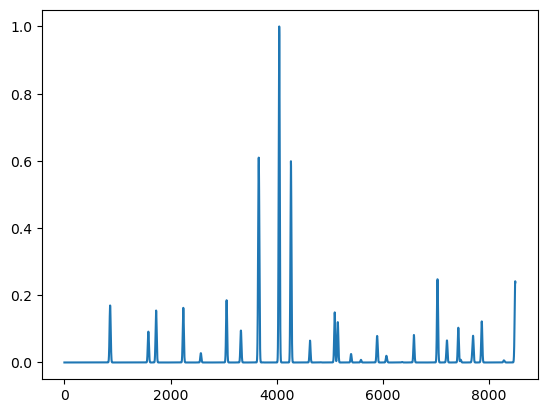

In [55]:
plt.plot(list(train_dict[key].numpy().flatten()))

Merge together the data from different peak shapes

In [70]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import torch 
import os
import random 

num_workers = 1
dataset_names =  ['train', 'test', 'val']
data_source = "mp_20"
data_dir = '/home/gridsan/tmackey/cdvae/data/mp_20_final_reproduction/'
# peak_shapes = [(0.05, -0.06, 0.07), (0.05, -0.01, 0.01),
#                    (0.0, 0.0, 0.01), (0.0, 0.0, random.uniform(0.001, 0.1))]
noise = 0 #no noise for now, will add it dymically during training unless there's a good reason to do otherwise
peak_shapes = [(0.05, -0.06, 0.07)]

for name in dataset_names:
    total_dict = {}
    for peak_shape, (U, V, W) in enumerate(peak_shapes):
        for worker_num in tqdm(range(num_workers)):
            subdict = torch.load(data_dir + 'worker_dir/' + f'{name}_sim_pv_xrd_intensities_{peak_shape}_worker_{worker_num}.pt')
            total_dict.update(subdict)
    print("total_dict length", len(total_dict))
    output_filepath = os.path.join(data_dir, f'{name}_pv_xrd.pt')
    torch.save(total_dict, output_filepath)
    print(f"Saved {name} dataset")

100%|██████████| 1/1 [00:00<00:00, 60.83it/s]


total_dict length 361
Saved train dataset


100%|██████████| 1/1 [00:00<00:00, 285.62it/s]


total_dict length 46
Saved test dataset


100%|██████████| 1/1 [00:00<00:00, 300.99it/s]

total_dict length 46
Saved val dataset
